In [82]:
#load packages for notebook
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [83]:
#define global variabels
period="max"
interval="1mo"
pricetype="Close"
start_date = "2024-01-01"
end_date = "2024-12-31"
title="Portfolio and Indices Evolution 2024"

In [84]:
#define yahoo tickers for base data for investment controlling
tickers = ['SPY','IEV','EWJ','EWL','EEM','GLD']

In [85]:
#define strategic weights for investment strategies
weights = {
    "SPY": 0.3,
    "IEV": 0.2,
    "EWJ": 0.3,
    "EWL": 0.05,
    "EEM": 0.1,
    "GLD": 0.05
}

In [86]:
#get the price data
#for this notebook we use the max data possible, a MoM price frequency and use the closing price
def load_monthly_data(tickers, period=period, interval=interval,pricetype=pricetype):
    
    all_data = {}

    for ticker in tickers:
        etf = yf.Ticker(ticker)
        hist = etf.history(period=period, interval=interval)
        all_data[ticker] = hist[pricetype]  # use "Adj Close" if available

    df = pd.DataFrame(all_data)
    df = df.dropna()

    return df

In [87]:
#price data gets loaded according to tickers
pricedata = load_monthly_data(tickers)

In [88]:
#data transformation for investment controlling dashboard
def compute_returns(pricedata, tickers):

    for ticker in tickers:
        ret_col = f"ret_{ticker.lower()}"
        index_col = f"index_{ticker.lower()}"
        
        pricedata[ret_col] = pricedata[ticker].pct_change()

        pricedata.loc[pricedata.index[0], ret_col] = 0

    return pricedata

In [89]:
pricedata_transformed = compute_returns(pricedata, tickers)

In [ ]:
def compute_indices_and_plot_with_labels(pricedata, tickers, weights, start_date=None, end_date=None, title="Portfolio and Indices"):
    """
    Compute cumulative indices, calculate portfolio, and plot evolution with labels at the end of each line.
    """
    
    # Slice data based on start_date and end_date
    data = pricedata.copy()
    if start_date and end_date:
        data = data.loc[start_date:end_date]
    elif start_date:
        data = data.loc[start_date:]
    elif end_date:
        data = data.loc[:end_date]
    
    # Compute indices normalized to 1 at first row
    index_cols = {}
    for ticker in tickers:
        ret_col = f"ret_{ticker.lower()}"
        index_col = f"index_{ticker.lower()}"
        index_cols[index_col] = (1 + data[ret_col]).cumprod()
        index_cols[index_col] /= index_cols[index_col].iloc[0]  # normalize
    
    data_indices = pd.DataFrame(index_cols, index=data.index)
    
    # Compute portfolio index
    weights_lower = {k.lower(): v for k, v in weights.items()}
    data_indices["index_portfolio"] = sum(
        data_indices[f"index_{ticker}"] * weight for ticker, weight in weights_lower.items()
    )
    
    # Plotting with end-line labels
    plt.figure(figsize=(12,6))
    for col in data_indices.columns:
        if col == "index_portfolio":
            plt.plot(data_indices.index, data_indices[col], linewidth=2.5, color='black')
            plt.text(data_indices.index[-1], data_indices[col].iloc[-1], "PORTFOLIO",
                     fontsize=10, fontweight='bold', va='center', ha='left', color='black')
        else:
            plt.plot(data_indices.index, data_indices[col], alpha=0.7)
            plt.text(data_indices.index[-1], data_indices[col].iloc[-1], col.replace("index_", "").upper(),
                     fontsize=9, va='center', ha='left', alpha=0.8)
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Normalized Index")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return data_indices

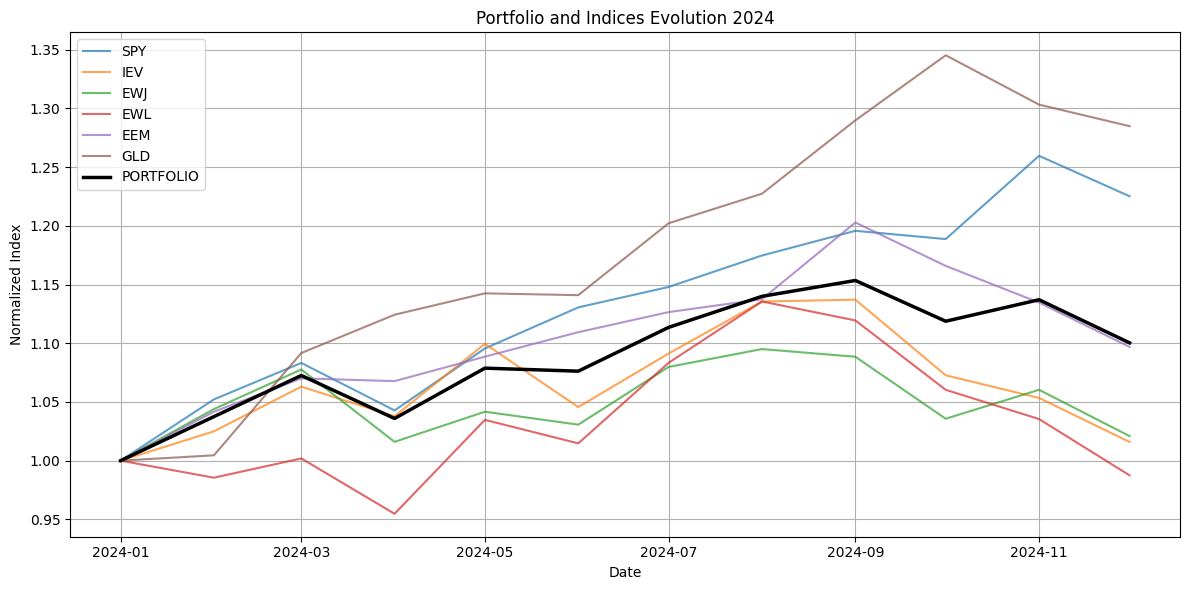

In [91]:
indices_2024 = compute_indices_and_plot(pricedata, tickers, weights, start_date, end_date,
                                        title=title)